# Tâche 2 - Corriger les proverbes avec des modèles de langue N-grammes

L'objectif de cette tâche est de corriger des proverbes à l'aide de modèles de langue N-grammes en remplaçant un mot incorrect dans un proverbe connu. Il s'agit d'une tâche qui consiste à choisir le meilleur mot à insérer dans un texte en fonction du contexte de la phrase. 

Voir l'énoncé du travail #1 pour une description plus détaillée de cette tâche. 

Fichiers:
- *t2_proverbes.txt*: il contient plus de 3000 proverbes, un par ligne de texte. Vous utilisez ce fichier pour l'entraînement des modèles de langues N-grammes. 
- *t2_test1.json*: il contient des proverbes modifiés, les mots candidats de remplacement et la bonne formulation du proverbe. À utiliser pour évaluer la capacité des modèles de langue N-grammes à mettre les bons mots aux bons endroits. 

Consignes: 
- Utilisez NLTK pour construire les modèles de langue.
- Utilisez Spacy pour la tokenisation des textes et pour identifier les mots à remplacer. 
- N'oubliez pas de faire le rebourrage (*padding*) des proverbes avec des symboles de début et de fin.
- Faites un lissage de Laplace des modèles. 
- Ne pas modifier les fonctions *load_proverbs* et *load_tests*.
- Utilisez la variable *models* pour conserver les modèles après entraînement. 
- Ne pas modifier la signature de les fonctions *train_models* et *correct_proverb*.
- Des modifications aux signatures de fonctions entraîneront des pénalités dans la correction. 
- Vous pouvez ajouter des cellules au *notebook* et ajouter toutes les fonctions utilitaires que vous voulez. 

## Chargement des librairies

In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import spacy
import re
import numpy as np

import nltk
from nltk.lm import Vocabulary
from nltk import word_tokenize
from nltk.util import ngrams, pad_sequence
from nltk.lm.models import Laplace

/home/nibou/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 1 - Lecture des fichiers de données (proverbes et tests)

In [2]:
# Ne pas modifier le chemin de ces 2 fichiers pour faciliter notre correction
proverbs_fn = "./data/t2_proverbes.txt"    
test_v1_fn = './data/t2_test1.json'

def load_proverbs(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        raw_lines = f.readlines()
    return [x.strip() for x in raw_lines]


def load_tests(filename):
    with open(filename, 'r', encoding='utf-8') as fp:
        test_data = json.load(fp)
    return test_data

In [3]:
proverbs = load_proverbs(proverbs_fn)

In [4]:
print("Nombre de proverbes pour l'entraînement: {}".format(len(proverbs)))
print("Un exemple de proverbe: " + proverbs[10])

Nombre de proverbes pour l'entraînement: 3108
Un exemple de proverbe: affaire menée sans bruit se fait avec plus de fruit


In [5]:
tests = load_tests(test_v1_fn)

In [6]:
def get_dataframe(test_proverbs):
    return pd.DataFrame.from_dict(test_proverbs, orient='columns', dtype=None, columns=None)

df = get_dataframe(tests)
df

,Masked,Word_list,Proverb
0,a beau mentir qui part de loin,"[vient, revient]",a beau mentir qui vient de loin
1,a beau dormir qui vient de loin,"[partir, mentir]",a beau mentir qui vient de loin
2,l’occasion forge le larron,"[fait, occasion]",l’occasion fait le larron
3,"endors-toi, le ciel t’aidera","[bouge, aide]","aide-toi, le ciel t’aidera"
4,"aide-toi, le ciel t’aura","[aidera, aide]","aide-toi, le ciel t’aidera"
5,"ce que femme dit, dieu le veut","[dit, veut]","ce que femme veut, dieu le veut"
6,"ce que femme veut, dieu le souhaite","[dit, veut]","ce que femme veut, dieu le veut"
7,bien mal acquis ne sait jamais,"[profite, fait]",bien mal acquis ne profite jamais
8,bon ouvrier ne déplace pas ses outils,"[fait, querelle]",bon ouvrier ne querelle pas ses outils
9,"pour le fou, c’était tous les jours fête","[est, es]","pour le fou, c’est tous les jours fête"


## Section 2 - Code pour repérer les mots qui pourraient être remplacés dans un proverbe modifié

Expliquez ici comment vous procédez pour identifier les mots d'un proverbe qui pourraient faire l'objet d'une substitution.  



In [7]:
nlp = spacy.load("fr_dep_news_trf")

In [8]:
def normalize_french_text(text):
    text = re.sub(r"(\w)-(\w)", r"\1 \2", text)
    text = re.sub(r"(\w)’(\w)", r"\1 \2", text)
    return text

def get_verb(tokens):
    verbs = []
    for token in tokens:
        if (token.pos_ == "VERB" or token.pos_ == "AUX" ) and token.text != "a" :
            verbs.append(token)
    
    return verbs

proverb = "pour le fou, c’était tous les jours fête"
normalized_proverb = normalize_french_text(proverb)
tokens = nlp(normalized_proverb)
verbs = get_verb(tokens)

## Section 3 - Construction des modèles de langue N-grammes. 

La fonction ***train_models*** prend en entrée une liste de proverbes et construit les trois modèles unigramme, bigramme et trigramme.

Les 3 modèles entraînés sont conservés dans ***models***, un dictionnaire Python qui prend la forme 

<pre>
{
   1: modele_unigramme, 
   2: modele_bigramme, 
   3: modele_trigramme
}
</pre>

avec comme clé la valeur N du modèle et comme valeur le modèle construit par NLTK.

Expliquez ici comment vous procéder pour construire vos modèles avec NLTK, pour obtenir les n-grammes de mots, pour déterminer le vocabulaire, etc...

...

In [9]:
BOS = '<BOS>'  # Jeton de début de proverbe
EOS = '<EOS>'  # Jeton de fin de proverbe

models = {} 

### Construction du vocabulaire

In [10]:
tokenized_proverbs = [word_tokenize(proverb) for proverb in proverbs]
flat_tokens = [token for sublist in tokenized_proverbs for token in sublist]
vocabulary = Vocabulary([BOS, EOS] + flat_tokens, unk_cutoff=1)

print("Taille du vocabulaire: {}".format(len(vocabulary)))

Taille du vocabulaire: 4473


### Construction des ngrams

In [11]:
def train_models(proverbs):
    """ Vous ajoutez à partir d'ici le code dont vous avez besoin
        pour construire les différents modèles N-grammes.
        Cette fonction doit construire tous les modèles en une seule passe.
        Voir les consignes de l'énoncé du travail pratique concernant les modèles à entraîner.

        Vous pouvez ajouter les fonctions/méthodes et variables que vous jugerez nécessaire.
        Merci de ne pas modifier la signature et le comportement de cette fonction (nom, arguments, sauvegarde des modèles).
    """

    orders = [1, 2, 3]

    for order in orders:
        all_ngrams = []
        for sentence in tokenized_proverbs:
            padded_sent = list(pad_sequence(sentence, pad_left=True, left_pad_symbol=BOS, pad_right=True, right_pad_symbol=EOS, n=order))
            all_ngrams.extend(list(ngrams(padded_sent, n=order)))
        
        models[order] = Laplace(order)
        models[order].fit([all_ngrams], vocabulary_text=vocabulary)

    return

train_models(proverbs)

### Test

In [12]:
models[2].score("le", ["chien"])

0.00022114108801415304

## Section 4 - Corriger un proverbe

In [13]:
def is_infinitive_verb(token):
    
    return 'VerbForm=Inf' in token.morph  

def correct_proverb(modified_proverb, word_list, n=3, criteria="perplexity"):
    """ Le paramètre criteria indique la mesure qu'on utilise 
        pour choisir le mot le plus approprié : "logprob" ou "perplexity".
        On retourne l'estimation de cette mesure sur le proverbe complet,
        c.-à-d. en utilisant tous les mots du proverbe.

        Le paramètre n désigne le modèle utilisé.
        1 - unigramme NLTK, 2 - bigramme NLTK, 3 - trigramme NLTK
        
        Cette fonction retourne la solution (le proverbe corrigé) et 
        la valeur de logprob ou perplexité (selon le paramètre en entrée de la fonction). 
    """

    # ---- trouver les verbes dans le proverbe modifié ----
    normalized_proverb = normalize_french_text(modified_proverb)
    verb_tokens = get_verb(nlp(normalized_proverb))
    verbs = [token.text for token in verb_tokens]
    tokens = [token.text for token in nlp(modified_proverb)]

    # ---- transformer la liste de mots en instances de tokens spaCy ----
    word_tokens = [nlp(word)[0] for word in word_list]

    # ---- initialiser le meilleur proverbe et le meilleur score ----
    best_proverb = ""
    best_score = -np.inf if criteria == "logprob" else np.inf

    for word in word_tokens:
        for verb in verb_tokens:
            for i, token in enumerate(tokens):
                new_sentence = tokens.copy()
                if token == verb.text :

                    # ---- remplacer le verbe par le mot dans la phrase ----
                    new_sentence[i] = word.text

                    # ---- on ne remplace pas un verbe à l'infinitif par un verbe non-infinitif et vice versa ----
                    if (is_infinitive_verb(verb) and not is_infinitive_verb(word)) or (not is_infinitive_verb(verb) and is_infinitive_verb(word)):
                        continue

                    # ---- transformer la nouvelle phrase en n-grammes ----
                    padded_sent = list(pad_sequence(new_sentence, pad_left=True, left_pad_symbol=BOS, pad_right=True, right_pad_symbol=EOS, n=n))
                    n_gram_sentence = ngrams(padded_sent, n=n)

                    # ---- évaluer la nouvelle phrase ----
                    if criteria == "perplexity":
                        perplexity = models[n].perplexity(n_gram_sentence)
                        if perplexity < best_score:
                            best_score = perplexity
                            best_proverb = " ".join(new_sentence)
                            best_proverb = re.sub(r"\s([.,!?])", r'\1', best_proverb)  # Retirer l'espace avant la ponctuation
                            best_proverb = re.sub(r"\s-\s", r'-', best_proverb)        # Retirer pour la ponctuation -
                            best_proverb = re.sub(r"’\s", r"’", best_proverb)          # Retirer l'espace après une apostrophe
                    
                    else:
                        logprob = 0
                        for ngram in n_gram_sentence:
                            logprob += models[n].score(ngram[-1], ngram[:-1])
                        if logprob > best_score:
                            best_score = logprob
                            best_proverb = " ".join(new_sentence)
                            best_proverb = re.sub(r"\s([.,!?])", r'\1', best_proverb)  # pareil
                            best_proverb = re.sub(r"\s-\s", r'-', best_proverb)        # pareil
                            best_proverb = re.sub(r"’\s", r"’", best_proverb)          # pareil


    # ---- si nous n'avons pas trouvé de meilleur proverbe, nous retournons le proverbe modifié ----
    if best_proverb == modified_proverb:

        new_word_list = [word.text for word in word_tokens]
        for word in word_tokens:
            if word.text in verbs:
                new_word_list.remove(word.text)
        
        return correct_proverb(modified_proverb, new_word_list, n=n, criteria=criteria)
                

    return best_proverb, best_score


Un exemple pour illustrer l'utilisation de cette fonction

In [14]:
masked =  "étudier peu, chasse beaucoup de maladies"
word_list = ["manger", "parle"] 
correct_proverb(masked, word_list, n=3, criteria="logprob")
# answer: "manger peu, chasse beaucoup de maladies"

('manger peu, chasse beaucoup de maladies', 0.004415131365014679)

## Section 5 - Expérimentations et analyse de résultats

Menez votre expérimentation dans cette section. Décrivez les résultats obtenus et présentez l'évaluation obtenue sur le(s) fichier(s) de test. Vous pouvez ajouter le nombre de cellules que vous souhaitez. 

### Présentation du meilleur résultat sous forme de dataframe

* La colonne **Masked** correspond au proverbe qui a été modifié
* La colonnne **Verbe_Founded** correspond aux verbes qui ont été trouvé par Spacy
* La colonne **Word_list** correspond aux deux verbes que notre programme doit choisir et remplacer au bon endroit dans le proverbe pour que celui-ci soit corrigé
* La colonne **Proverb** représente la solution
* La colonne **Our_proverb** est le résultat renvoyé par notre programme
* La colonne **Score** nous renvoit le score de perplexité ou logprob (à choisir) qu'a obtenu notre résultat
* La colonne **Equal** nous dit si notre résultat est équivalent à la solution

In [15]:
score = 0
df_results = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])

def results(degree, criteria):
    score = 0
    for i, row in df.iterrows():
        our_proverb = correct_proverb(row['Masked'], row['Word_list'], n=degree, criteria=criteria)

        normalized_proverb = normalize_french_text(row['Masked'])
        verbs = get_verb(nlp(normalized_proverb))
        
        if our_proverb[0] == row['Proverb']:
            score += 1
            df_results.loc[len(df_results)] = {'Masked': row['Masked'], 'Verb_Founded': verbs, 'Word_list': row['Word_list'], 'Proverb': row['Proverb'], 'Our_proverb': our_proverb[0], 'Score': our_proverb[1], 'Equal': True}
        else:
            df_results.loc[len(df_results)] = {'Masked': row['Masked'], 'Verb_Founded': verbs, 'Word_list': row['Word_list'], 'Proverb': row['Proverb'], 'Our_proverb': our_proverb[0], 'Score': our_proverb[1], 'Equal': False}
    
    return score

score = results(3, "perplexity")
df_results

,Masked,Verb_Founded,Word_list,Proverb,Our_proverb,Score,Equal
0,a beau mentir qui part de loin,"[beau, mentir, part]","[vient, revient]",a beau mentir qui vient de loin,a beau mentir qui vient de loin,1804.106471,True
1,a beau dormir qui vient de loin,"[beau, dormir, vient]","[partir, mentir]",a beau mentir qui vient de loin,a beau mentir qui vient de loin,1804.106471,True
2,l’occasion forge le larron,[forge],"[fait, occasion]",l’occasion fait le larron,l’occasion fait le larron,2473.081509,True
3,"endors-toi, le ciel t’aidera","[endors, aidera]","[bouge, aide]","aide-toi, le ciel t’aidera","endors-toi, le ciel t’aide",3947.930684,False
4,"aide-toi, le ciel t’aura","[aide, aura]","[aidera, aide]","aide-toi, le ciel t’aidera","aide-toi, le ciel t’aide",3947.930684,False
5,"ce que femme dit, dieu le veut","[dit, veut]","[dit, veut]","ce que femme veut, dieu le veut","ce que femme veut, dieu le veut",1197.227964,True
6,"ce que femme veut, dieu le souhaite","[veut, souhaite]","[dit, veut]","ce que femme veut, dieu le veut","ce que femme veut, dieu le veut",1197.227964,True
7,bien mal acquis ne sait jamais,"[acquis, sait]","[profite, fait]",bien mal acquis ne profite jamais,bien mal acquis ne profite jamais,1416.865543,True
8,bon ouvrier ne déplace pas ses outils,[déplace],"[fait, querelle]",bon ouvrier ne querelle pas ses outils,bon ouvrier ne fait pas ses outils,1183.925007,False
9,"pour le fou, c’était tous les jours fête",[était],"[est, es]","pour le fou, c’est tous les jours fête","pour le fou, c’est tous les jours fête",1906.692921,True


In [16]:
print("Score: {}".format(score))

Score: 21


Le le Trigrams avec la **perplexité** nous a donné le meilleur resultat. En effet, ce modèle nous a permis de corriger 21 proverbes sur les 26 fournis. Ce résultat confirme le fait que les N-grams ont tendance a être plus performant lorsque le N, à savoir le nombre de mots dans l'évidence du calcul de probablité conditionnelle, augmente. On peut voir sur le graphe suivant à quel point ce modèle surperforme les 5 autres:

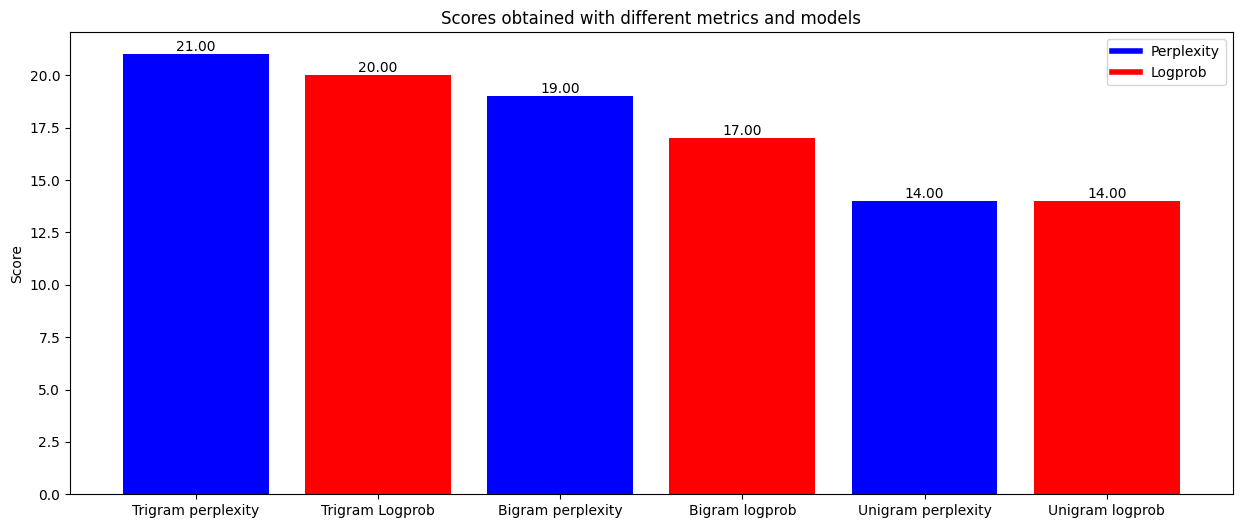

In [17]:
score3 = results(2, "perplexity") ; score5 = results(1, "perplexity") ; score2 = results(3, "logprob") ; score4 = results(2, "logprob") ; score6 = results(1, "logprob")
scores = [score, score2, score3, score4, score5, score6]
labels = ['Trigram perplexity', 'Trigram Logprob', 'Bigram perplexity' , 'Bigram logprob', 'Unigram perplexity', 'Unigram logprob']

figure = plt.figure(figsize=(15, 6))
bars = plt.bar(labels, scores, color=['blue', 'red', 'blue', 'red', 'blue', 'red'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{score:.2f}', ha='center', va='bottom')

blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Perplexity')
red_patch = plt.Line2D([0], [0], color='red', lw=4, label='Logprob')

plt.legend(handles=[blue_patch, red_patch])
plt.ylabel('Score')
plt.title('Scores obtained with different metrics and models')
plt.show()


On constate que le Trigram est le meilleur, mais que le Bigram n'est pas si loin, ce qui montre que ce modèle est déjà très efficace même si il est très simpliste. 

Ensuite, on remarque également une grande différence entre les différents scores. L'utilisation de la perplexité pour déterminer si un proverbe est meilleur qu'un autre est nettement plus performant que d'utiliser la logprob. Cela peut s'expliquer par le fait que perplexité prend en compte la probabilité moyenne de chaque mot dans une séquence tout en la normalisant en fonction de la longueur de la phrase, offrant ainsi une évaluation plus globale de la qualité du modèle. En revanche, la logprob mesure simplement la probabilité logarithmique d'une séquence sans ajustement pour la longueur ou la complexité, ce qui la rend moins fiable pour comparer des phrases de longueurs différentes. La perplexité permet donc de mieux capturer la fluidité et la cohérence d'une phrase, rendant cette mesure plus performante pour évaluer des proverbes dans ce contexte.

### Analyse des erreurs

On peut voir dans le tableau suivant les différents proverbes qui ont causés des problèmes à notre programme

In [18]:
df_results = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])
score = results(3, "perplexity")
df_incorrect = df_results[df_results['Equal'] == False].copy()
df_incorrect

,Masked,Verb_Founded,Word_list,Proverb,Our_proverb,Score,Equal
3,"endors-toi, le ciel t’aidera","[endors, aidera]","[bouge, aide]","aide-toi, le ciel t’aidera","endors-toi, le ciel t’aide",3947.930684,False
4,"aide-toi, le ciel t’aura","[aide, aura]","[aidera, aide]","aide-toi, le ciel t’aidera","aide-toi, le ciel t’aide",3947.930684,False
8,bon ouvrier ne déplace pas ses outils,[déplace],"[fait, querelle]",bon ouvrier ne querelle pas ses outils,bon ouvrier ne fait pas ses outils,1183.925007,False
17,il faut le voir pour le saisir,"[faut, voir, saisir]","[boire, croire]",il faut le voir pour le croire,il faut le voir pour le boire,803.335286,False
21,"repose-toi plutôt sans souper, que de te lever...","[repose, lever]","[lève, couche]","couche-toi plutôt sans souper, que de te lever...","lève-toi plutôt sans souper, que de te lever a...",2258.013867,False


Pour voir qu'est ce qu'il s'est passé, nous allons créer une dataframe avec toutes les solutions par lequel notre programme est passé.

In [19]:
df_incorrect_all_values = pd.DataFrame(columns=['Number','Proverb', 'Our_proverb', 'Score','Equal'])

def correct_proverb_analysis(modified_proverb, word_list,number, n=3,criteria="perplexity"):
    """ Le paramètre criteria indique la mesure qu'on utilise 
        pour choisir le mot le plus approprié: "logprob" ou "perplexity".
        On retourne l'estimation de cette mesure sur le proverbe complet,
        c.-à-d. en utilisant tous les mots du proverbe.

        Le paramètre n désigne le modèle utilisé.
        1 - unigramme NLTK, 2 - bigramme NLTK, 3 - trigramme NLTK
        
        Cette fonction retourne la solution (le proverbe corrigé) et 
        la valeur de logprob ou perplexité (selon le paramètre en entrée de la fonction). 
    """

    normalized_proverb = normalize_french_text(modified_proverb)
    verb_tokens = get_verb(nlp(normalized_proverb))
    tokens = [token.text for token in nlp(modified_proverb)]
    word_tokens = [nlp(word)[0] for word in word_list]

    for word in word_tokens:
        for verb in verb_tokens:
            for i, token in enumerate(tokens):
                new_sentence = tokens.copy()
                if token == verb.text :

                    new_sentence[i] = word.text

                    if (is_infinitive_verb(verb) and not is_infinitive_verb(word)) or (not is_infinitive_verb(verb) and is_infinitive_verb(word)):
                        continue

                    padded_sent = list(pad_sequence(new_sentence, pad_left=True, left_pad_symbol=BOS, pad_right=True, right_pad_symbol=EOS, n=n))
                    n_gram_sentence = ngrams(padded_sent, n=n)

                    if criteria == "perplexity":
                        perplexity = models[n].perplexity(n_gram_sentence)  
                        proverb = " ".join(new_sentence)
                        proverb = re.sub(r"\s([.,!?])", r'\1', proverb) 
                        proverb = re.sub(r"\s-\s", r'-', proverb)  
                        proverb = re.sub(r"’\s", r"’", proverb)
                        df_incorrect_all_values.loc[len(df_incorrect_all_values)] = {'Number': number, 'Proverb': modified_proverb, 'Our_proverb': proverb, 'Score': perplexity, 'Equal': False}
                
                    else:
                        logprob = models[n].logscore(n_gram_sentence)
                        proverb = " ".join(new_sentence)
                        proverb = re.sub(r"\s([.,!?])", r'\1', proverb)
                        proverb = re.sub(r"\s-\s", r'-', proverb)
                        proverb = re.sub(r"’\s", r"’", proverb) 
                        df_incorrect_all_values.loc[len(df_incorrect_all_values)] = {'Number': number, 'Proverb': modified_proverb, 'Our_proverb': proverb, 'Score': logprob, 'Equal': False}

    return

for i, row in df_incorrect.iterrows():
    correct_proverb_analysis(row['Masked'], row['Word_list'], i, n=3, criteria="perplexity")

df_incorrect_all_values


,Number,Proverb,Our_proverb,Score,Equal
0,3,"endors-toi, le ciel t’aidera","bouge-toi, le ciel t’aidera",4111.203184,False
1,3,"endors-toi, le ciel t’aidera","endors-toi, le ciel t’bouge",4406.179997,False
2,3,"endors-toi, le ciel t’aidera","aide-toi, le ciel t’aidera",4111.203184,False
3,3,"endors-toi, le ciel t’aidera","endors-toi, le ciel t’aide",3947.930684,False
4,4,"aide-toi, le ciel t’aura","aidera-toi, le ciel t’aura",4406.179997,False
5,4,"aide-toi, le ciel t’aura","aide-toi, le ciel t’aidera",4111.203184,False
6,4,"aide-toi, le ciel t’aura","aide-toi, le ciel t’aura",4406.179997,False
7,4,"aide-toi, le ciel t’aura","aide-toi, le ciel t’aide",3947.930684,False
8,8,bon ouvrier ne déplace pas ses outils,bon ouvrier ne fait pas ses outils,1183.925007,False
9,8,bon ouvrier ne déplace pas ses outils,bon ouvrier ne querelle pas ses outils,1316.499890,False


Les erreurs sont liés à la performance du modèle N-grams, comme on peut le voir dans la visualisation suivante:

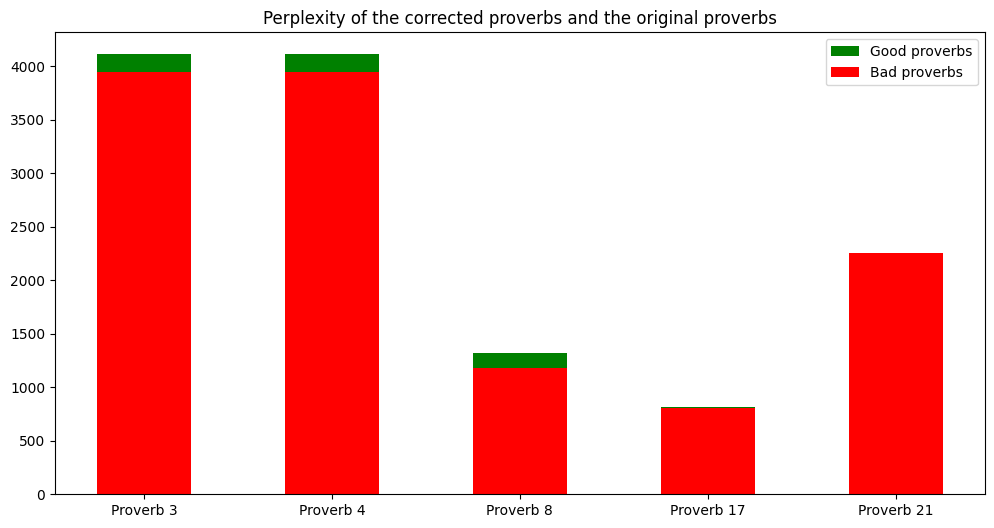

In [20]:
number3 = df_incorrect_all_values[df_incorrect_all_values['Number'] == 3].copy()
number4 = df_incorrect_all_values[df_incorrect_all_values['Number'] == 4].copy()
number8 = df_incorrect_all_values[df_incorrect_all_values['Number'] == 8].copy()
number17 = df_incorrect_all_values[df_incorrect_all_values['Number'] == 17].copy()
number21 = df_incorrect_all_values[df_incorrect_all_values['Number'] == 21].copy()

number3 = number3.sort_values(by='Score').head(2)["Score"].values
number4 = number4.sort_values(by='Score').head(2)["Score"].values
number8 = number8.sort_values(by='Score').head(2)["Score"].values
number17 = number17.sort_values(by='Score').head(2)["Score"].values
number21 = number21.sort_values(by='Score').head(2)["Score"].values

good_score = []
bad_score = []

good_score.append(number3[1])
good_score.append(number4[1])
good_score.append(number8[1])
good_score.append(number17[1])
good_score.append(number21[1])

bad_score.append(number3[0])
bad_score.append(number4[0])
bad_score.append(number8[0])
bad_score.append(number17[0])
bad_score.append(number21[0])

fig = plt.figure(10, figsize=(12, 6))
plt.bar(range(5), good_score, color='g', label='Good proverbs', width=0.5)
plt.bar(range(5), bad_score, color='r', label='Bad proverbs', width=0.5)
plt.xticks(range(5), ['Proverb 3', 'Proverb 4', 'Proverb 8', 'Proverb 17','Proverb 21'])
plt.title('Perplexity of the corrected proverbs and the original proverbs')
plt.legend()
plt.show()

On remarque ici que les scores de perplexité sont très proches entre le bon proverbe et le proverbe renvoyé par notre programme (Bad proverbs). Ils sont même égaux pour le proverbe 21, le programme a du faire un choix et a choisi le premier proverbe qu'il a testé. Ce graphe montre donc que même si notre programme n'a pas renvoyé la bonne solution, le modèle N-grams était quand même très proche de renvoyer le bon résultat, ce qui témoigne de son éfficacité.

## Section 6 - Partie réservée pour faire nos tests lors de la correction

Merci de ne pas modifier ni retirer cette section du notebook.  